### DATA 245: Assignment No. 4 #SJSU ID: 016978741

#### Ques:6 See file NaiveBayse_MNIST_Problems.ipynb

In [20]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
#from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [21]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
from sklearn.datasets import load_digits
mnist = load_digits()
X, Y = mnist.data, mnist.target

#np.random.seed(0)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)



# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]

data shape:  (1797, 64)
label shape: (1797,)


### A. Create a 10x10 grid to visualize 10 examples of each digit.

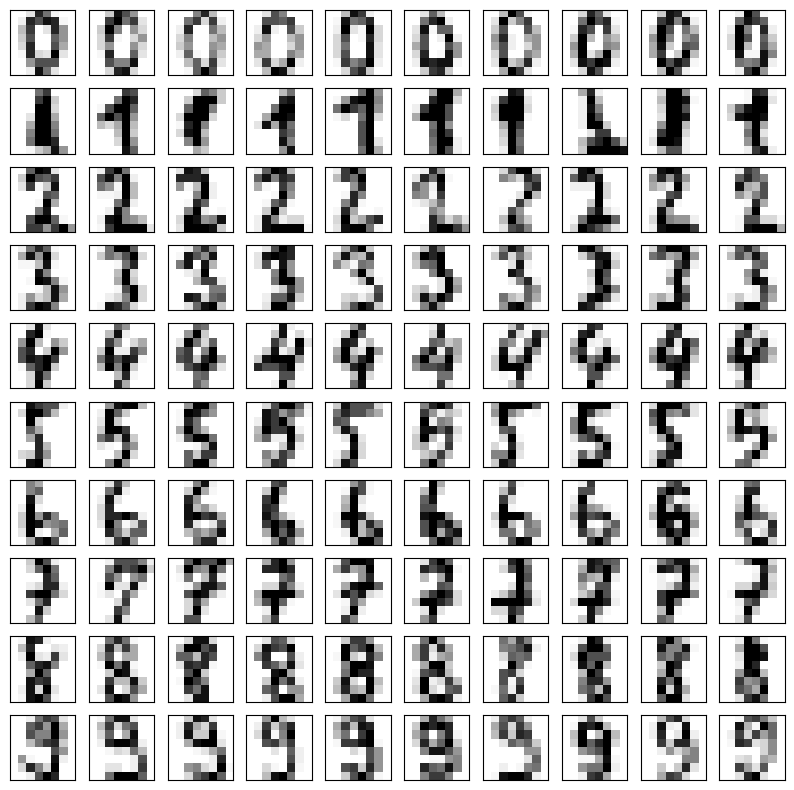

In [22]:

# Set the plot colormap
plt.rc('image', cmap='Greys')

# Set the plot size 
plt.figure(figsize=(10, 10))

# Loop through each digit
for digit in range(10):
    
    # Extract 10 examples for each digit
    examples = X[Y == digit][:10]
    
    # Loop through each example
    for index, image in enumerate(examples):
        
        # Setup the subplot in (row, col, location)
        plt.subplot(10, 10, digit * 10 + index + 1)
        
        # Reshape the image into a 8x8 matrix and plot
        plt.imshow(image.reshape(8, 8))
        
        # Get current ax instance 
        ax = plt.gca()
        
        # Hide axis labels
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.show()


### B.  Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?
### Note, the answers may vary depending on what thresholds you set.

In [23]:
print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]

data shape:  (1797, 64)
label shape: (1797,)


In [24]:

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

# Calculate quartile-based threshold using the train data
threshold = np.quantile(train_data, 0.5)  # 50th percentile (median)

# Binary Class
binarized_train_data = train_data.copy()
binarized_train_data[binarized_train_data <= threshold] = 0
binarized_train_data[binarized_train_data > threshold] = 1

binarized_dev_data = dev_data.copy()
binarized_dev_data[binarized_dev_data <= threshold] = 0
binarized_dev_data[binarized_dev_data > threshold] = 1

binarized_test_data = test_data.copy()
binarized_test_data[binarized_test_data <= threshold] = 0
binarized_test_data[binarized_test_data > threshold] = 1

# Fit Bernoulli Naive Bayes classifier
clf_binary = BernoulliNB(alpha=1)
clf_binary.fit(binarized_train_data, train_labels)
y_pred_dev = clf_binary.predict(binarized_dev_data)
y_pred_test = clf_binary.predict(binarized_test_data)

print('Binary accuracy on dev: ', clf_binary.score(binarized_dev_data, dev_labels))
print('Binary accuracy on test: ', clf_binary.score(binarized_test_data, test_labels))


Binary accuracy on dev:  0.8714285714285714
Binary accuracy on test:  0.8715953307392996


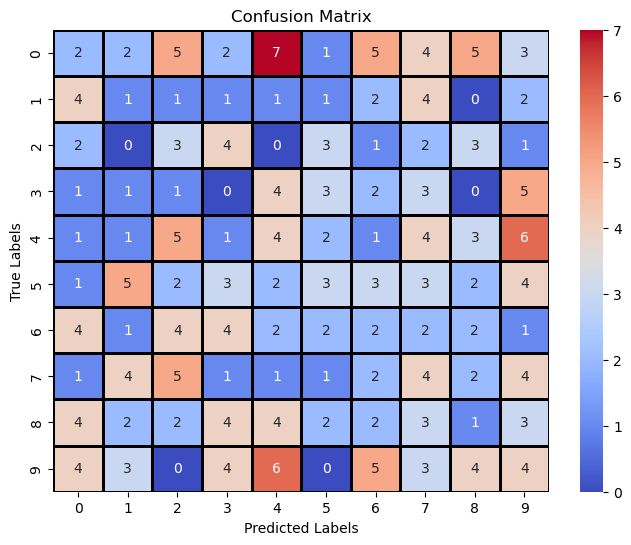

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix 

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, y_pred_test)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap= "coolwarm", linewidths= 2, linecolor= 'black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [26]:

# Calculate quartile-based thresholds using the train data
q1 = np.quantile(train_data, 0.25)  # 25th percentile
q3 = np.quantile(train_data, 0.75)  # 75th percentile

### Multi-class with Quartile-based Thresholds
multi_train_data = train_data.copy()
multi_train_data[multi_train_data <= q1] = 0
multi_train_data[np.logical_and(multi_train_data > q1, multi_train_data <= q3)] = 1
multi_train_data[multi_train_data > q3] = 2

multi_dev_data = dev_data.copy()
multi_dev_data[multi_dev_data <= q1] = 0
multi_dev_data[np.logical_and(multi_dev_data > q1, multi_dev_data <= q3)] = 1
multi_dev_data[multi_dev_data > q3] = 2

multi_test_data = test_data.copy()
multi_test_data[multi_test_data <= q1] = 0
multi_test_data[np.logical_and(multi_test_data > q1, multi_test_data <= q3)] = 1
multi_test_data[multi_test_data > q3] = 2


# Fit Multinomial Naive Bayes classifier
clf_trinary = MultinomialNB(alpha=1)
clf_trinary.fit(multi_train_data, train_labels)
y_pred_dev2 = clf_trinary.predict(multi_dev_data)
y_pred_test2 = clf_trinary.predict(multi_test_data)

print('Trinary accuracy on dev: ', clf_trinary.score(multi_dev_data, dev_labels))
print('Trinary accuracy on test: ', clf_binary.score(multi_test_data, test_labels))


Trinary accuracy on dev:  0.8142857142857143
Trinary accuracy on test:  0.8949416342412452


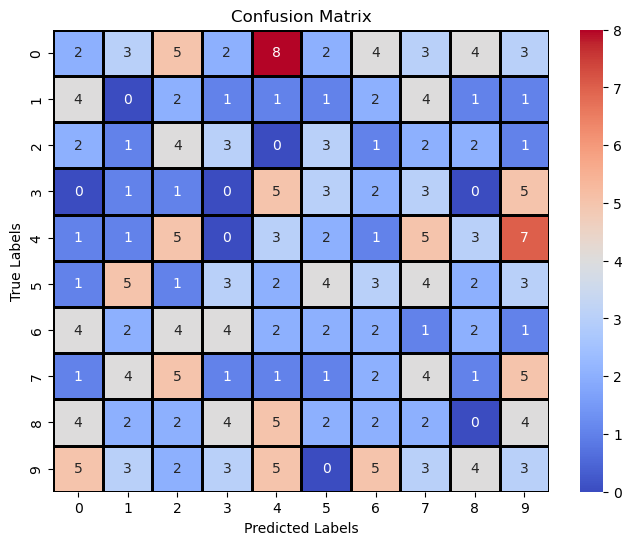

In [68]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, y_pred_test2)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap= "coolwarm", linewidths= 2, linecolor= 'black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### For thresholds: divide the range of pixels values into equal intervals.

In [28]:
# Set the range and number of thresholds
threshold_range = (0, 255)  # Range of pixel values (0 to 255 for 8-bit grayscale)
num_thresholds = 2  # Number of thresholds for binarization

# Generate evenly spaced thresholds using np.linspace
thresholds = np.linspace(threshold_range[0], threshold_range[1], num_thresholds + 1)[:-1]

### Binary Class
binarized_train_data = train_data.copy()
binarized_train_data[np.logical_and(binarized_train_data >= thresholds[0], binarized_train_data < thresholds[1])] = 0
binarized_train_data[binarized_train_data >= thresholds[1]] = 1

binarized_dev_data = dev_data.copy()
binarized_dev_data[np.logical_and(binarized_dev_data >= thresholds[0], binarized_dev_data < thresholds[1])] = 0
binarized_dev_data[binarized_dev_data >= thresholds[1]] = 1

binarized_test_data = test_data.copy()
binarized_test_data[np.logical_and(binarized_test_data >= thresholds[0], binarized_test_data < thresholds[1])] = 0
binarized_test_data[binarized_test_data >= thresholds[1]] = 1

# Fit Bernoulli Naive Bayes classifier
clf_binary = BernoulliNB(alpha=1)
clf_binary.fit(binarized_train_data, train_labels)
print('Binary accuracy on dev: ', clf_binary.score(binarized_dev_data, dev_labels))
print('Binary accuracy on test: ', clf_binary.score(binarized_test_data, test_labels))

Binary accuracy on dev:  0.07142857142857142
Binary accuracy on test:  0.08949416342412451


In [29]:
threshold1 = 80
threshold2 = 165
# Map pixel values to 0, 1, or 2 based on custom thresholds
multi_train_data = train_data.copy()
multi_train_data[multi_train_data <= threshold1] = 0
multi_train_data[np.logical_and(multi_train_data > threshold1, multi_train_data <= threshold2)] = 1
multi_train_data[multi_train_data > threshold2] = 2

multi_dev_data = dev_data.copy()
multi_dev_data[multi_dev_data <= threshold1] = 0
multi_dev_data[np.logical_and(multi_dev_data > threshold1, multi_dev_data <= threshold2)] = 1
multi_dev_data[multi_dev_data > threshold2] = 2

multi_test_data = test_data.copy()
multi_test_data[multi_test_data <= threshold1] = 0
multi_test_data[np.logical_and(multi_test_data > threshold1, multi_test_data <= threshold2)] = 1
multi_test_data[multi_test_data > threshold2] = 2

# Fit Multinomial Naive Bayes classifier
clf_trinary = MultinomialNB(alpha=1)
clf_trinary.fit(multi_train_data, train_labels)

print('Trinary accuracy on dev: ', clf_trinary.score(multi_dev_data, dev_labels))
print('Trinary accuracy on test: ', clf_binary.score(multi_test_data, test_labels))


Trinary accuracy on dev:  0.07142857142857142
Trinary accuracy on test:  0.08949416342412451


For BernouliNB we checked the threshold at different levels using quartile-based threshold and also dividing the range of pixels into equal intervals for binaryNB and multinomialNB. The accuracy was close to 87% and 0.071 using both threshold method for BinaryNB. We also plotted the confusion matrix.
For MultinomialNB we mapped the features in the range 0,1,2 by using the above two thresholds methods and the accuracy was slightly low as compared to BernouliNB ie. around 81%. The accuracy didn't approve with multinomialnb because multinomialnb is more suitable for occurrence counts. However, the bernouli is designed for binary data that's why the accuracy is more on bernoulinb model.Also, one thing to derive is that adding too many features may decrease the accuracy and result in overfitting.

### C. Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Could you explain why?

In [37]:
X, Y = mnist.data, mnist.target
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]


test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]

In [55]:
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np
mnist = load_digits()

X, Y = mnist.data, mnist.target

# Shuffle the data
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split the data into train, dev, and test sets
test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]

# Fit Gaussian Naive Bayes classifier on the train data
clf_gaussian = GaussianNB()
clf_gaussian.fit(train_data, train_labels)

# predict on the dev data
y_pred_dev = clf_gaussian.predict(dev_data)

# Evaluate on the dev data
dev_accuracy = accuracy_score(dev_labels, clf_gaussian.predict(dev_data))
print('Gaussian NB accuracy on dev:', dev_accuracy)


Gaussian NB accuracy on dev: 0.7642857142857142


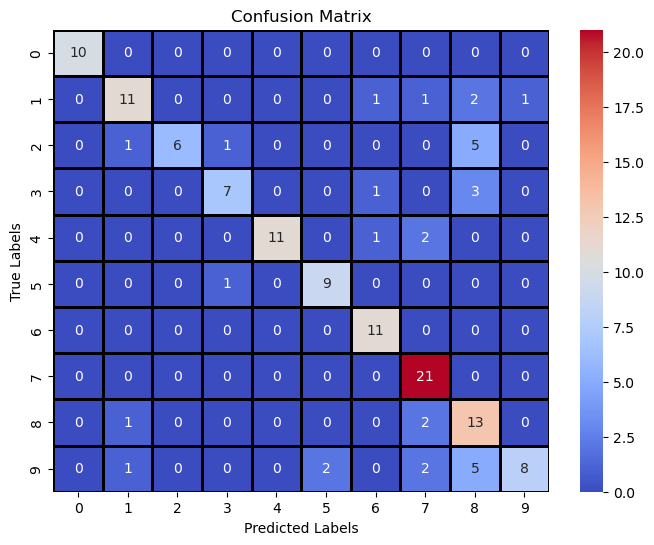

In [67]:
# Calculate the confusion matrix
cm = confusion_matrix(dev_labels, y_pred_dev)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap= "coolwarm", linewidths= 2, linecolor= 'black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [57]:
from sklearn.metrics import precision_score
round(precision_score(dev_labels,y_pred_dev, average='macro')*100,2)

82.71

In [58]:
from sklearn.metrics import recall_score
round(recall_score(dev_labels,y_pred_dev, average='macro')*100,2)

77.28

In [60]:
X.shape[0]
random_index = np.random.choice(X.shape[0])

Text(0.5, 1.0, 'Histogram of a Features')

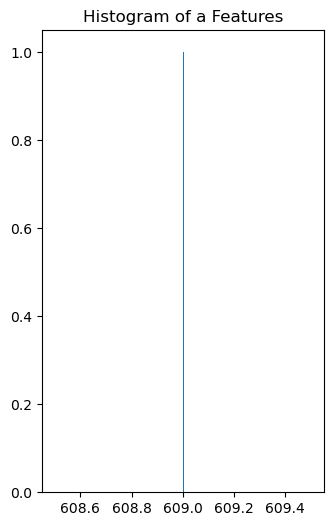

In [65]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
fig = plt.hist(random_index, 200)
plt.title('Histogram of a Features')

Guassian Naive Baye's Classifier didnt perform this well with the digits dataset as it assumes that pixel values follows a Guassian (normal)distribution, however, the image digits data here do not follow the guassian(normal) distribution. The pixel data in image data is usually discrete, therefore its best to use Bernouli Naive Bayes classifier(for binarised data) and Multinomial (for multi class data). Also, we see there are many false positives and false negatives as the precsion and recall is low. Also, we draw the histogram that show the distribution of features, we can very well see the distribution is not normal.

Thank You!!